# Using Tensorflow 2.x Transfer Learning to classify breeds of Dogs 🐶

### **About the competition ([Dog breed classification](https://www.kaggle.com/c/dog-breed-identification/overview)):** 

This compition is to predict the Dog breeds. It consists of a collection of 10,000+ labelled images of 120 different dog breeds. 

### **Kind of ML Problem**
This kind of problem is called multi-class image classification. It's multi-class because we're trying to classify mutliple different breeds of dog. If we were only trying to classify dogs versus cats, it would be called binary classification.

### **TensorFlow/Deep Learning workflow we will be using:**
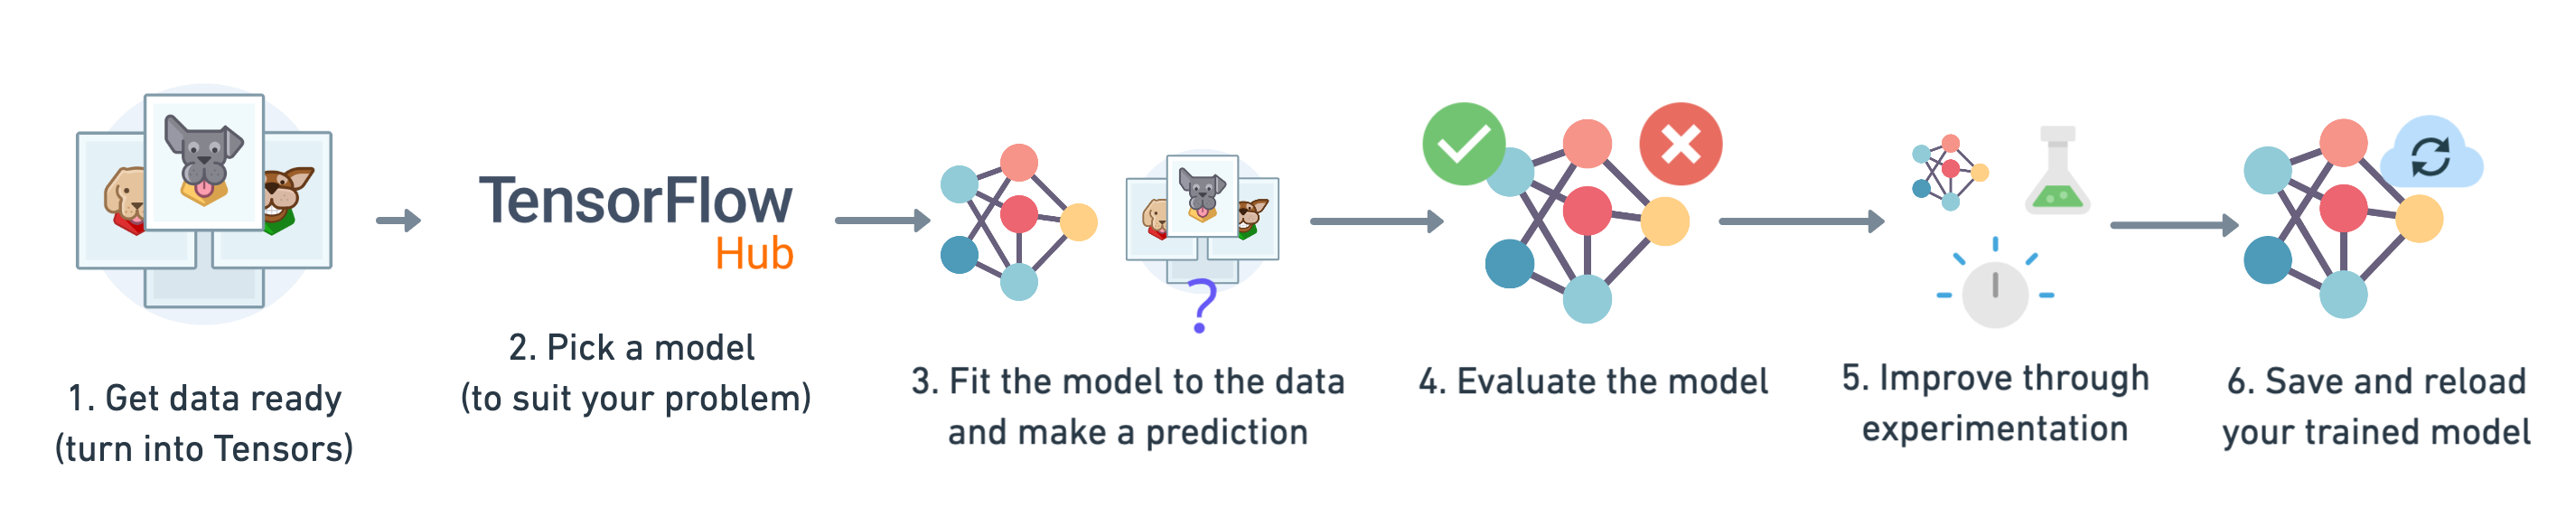

1. Getting data ready import dataset.
2. Visualize the Dataset. 
3. Preprocess the Dataset for Tensorflow format.
4. Prepare Tensorflow Tranfer learning Model. 
5. Train the model. 
6. Visualize the model results. 
7. Predict on test model.

## Getting data ready import dataset.

In [ ]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt 
import os 

import tensorflow as tf

In [ ]:
dir_path = "../input/dog-breed-identification/"
os.listdir(dir_path)


In [ ]:
  for dirpath, dirnames, filenames in os.walk(dir_path ):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

Hmm, We learnt from here two things: 

* There are 10222 images in train folder which will be used for training. 
* There are 10357 images in test folder which will be used for testing. 

In [ ]:
train_images_path = "../input/dog-breed-identification/train/"
test_images_path = "../input/dog-breed-identification/test/"

In [ ]:
#Lets read labels.csv file and check whats in that 
labels_df = pd.read_csv(dir_path + 'labels.csv')
print(labels_df.head())
print(labels_df.describe())

Ok. In the labels, we have images 'id' and 'breed' which is actually our Target labels. These labels our model need to predict. Great! 

In [ ]:
#Lets check if images in labels.csv is equal to images in our train folder 

def is_equal_images(target_dir, target_df): 
    """
    This function will check if target_dir images are equal to image list in target_df
    """
    len_target_dir = len(os.listdir(target_dir))
    len_target_df = len(target_df)
    if len_target_dir == len_target_df: 
        print(f"Both are having same no of images:{len_target_dir}")
    else: 
        print(f"Target dir having {len_target_dir} images while Target DF having {len_target_df}")
        
is_equal_images(target_dir = train_images_path, target_df = labels_df)

Great, both are having no of images. That, means there are no missing files. 

### 2.Visualize the input data 



In [ ]:
#check one image from training data
from IPython.display import Image, display
Image(train_images_path + '000bec180eb18c7604dcecc8fe0dba07.jpg')

In [ ]:
#Check how many images per breed of dog. 

labels_df['breed'].value_counts().plot.bar(figsize=(20,10))
print(f"Average Images per breed:{int(labels_df['breed'].value_counts().sum()/len(labels_df['breed'].unique()))}")
print(f"Total no of breeds:{len(labels_df['breed'].unique())}")

* So, there are 120 breeds. 
* On an average there are around 85 images. Thats, a good number. 

So, making ML model from scratch will not be good option as images are pretty less. 
So, What can we do? 

We can take help of **Transfer Learning**. 

The process of using a pretrained model and adapting it to your own problem is called transfer learning. We do this because rather than train our own model from scratch (could be timely and expensive), we leverage the patterns of another model which has been trained to classify images. 

## Process train & Test data

In [ ]:
#Create an array of train images 
filenames = [train_images_path + fname + '.jpg' for fname in labels_df['id']]
filenames[:10]

In [ ]:
# Create class names array 
class_names = labels_df['breed'].unique()
class_names[:10]

In [ ]:
target_labels = [breed for breed in labels_df['breed']]
target_labels[:10]

#### Convert labels to one-hot encoded 

🔑**Remember:** An important concept in machine learning is converting your data to numbers before passing it to a machine learning model.

In [ ]:
# Example: Turn one label into array of boolean 
print(target_labels[0])
target_labels[0] == class_names

In [ ]:
#Lets do for all the labels 

target_labels_encoded = [label == np.array(class_names) for label in target_labels]
target_labels_encoded[:2]

In [ ]:
# Example: Turning a boolean array into integers
print(target_labels[0]) # original label
print(np.where(class_names == target_labels[0])[0][0]) # index where label occurs
print(target_labels_encoded[0].argmax()) # index where label occurs in boolean array
print(target_labels_encoded[0].astype(int)) # there will be a 1 where the sample label occurs

Wonderful! Now we've got our labels in a numeric format and our image filepaths easily accessible (they aren't numeric yet), let's split our data up.

### Split Train & validation data

In [ ]:
#Import train test split from sklearn 

from sklearn.model_selection import train_test_split 

#Experiement with small data 1000 images 
NUM_IMAGES = 2000

#Split data into training & validation 
X_train, X_val, Y_train, Y_val = train_test_split(filenames[:NUM_IMAGES], target_labels_encoded[:NUM_IMAGES], test_size=0.2, random_state=42)

len(X_train), len(X_val), len(Y_train), len(Y_val)

In [ ]:
#Check our the training data 

X_train[0], Y_train[0]

## 3. Preprocess the Dataset in Tensorflow format. 

Since, we are using Tensorflow for modeling, our data needs to be in Tensorflow format. 

A Tensor is a way to represent information in numbers. If you're familar with NumPy arrays (you should be), a Tensor can be thought of as a combination of NumPy arrays, except with the special ability to be used on a GPU.

Because of how TensorFlow stores information (in Tensors), it allows machine learning and deep learning models to be run on GPUs (generally faster at numerical computing).

To preprocess our image we will write a function to do so: 

1. Take image file path. 
2. Read image from path using Tensorflow. 
3. Convert image to Tensor. 
4. Resize our image into fixed Tensor shape (224,224,3) 
5. Return the image

📑 **Refrence**: You can read more about Tensorflow dataset from here: https://www.tensorflow.org/tutorials/load_data/images

In [ ]:
#Random image and its shape 
from matplotlib.pyplot import imread

img = imread(X_train[0])
plt.imshow(img)
print(f"Image Shape: {img.shape}")

Since, our model can take a fixed image size (224,224) for our model. So, each of the image we will convert to this shape. 

We can use `tf.constant()` to convert image to TF tensor. 

In [ ]:
tf.constant(img)

As we can see from the, our image `dtype` is `uint8` and tensorflow like data into `float32`. And we will also normalize our images by diving by 255 for values between 0 and 1.

In [ ]:
tf.image.convert_image_dtype(img, tf.float32)

In [ ]:
IMAGE_SIZE = 224

# Lets write our preprocessing function
def process_image(image_path): 
    """
    This function will read image, resize the image and return into TF format. 
    Arguments: 
        image_path(str): Path of image
    Returns: 
        img: Tensor image
    """
    img = tf.io.read_file(image_path)
    # Turn the jpeg image into numerical Tensor with 3 colour channels (Red, Green, Blue)
    img = tf.io.decode_image(img, channels =3)
    # Convert the colour channel values from 0-225 values to 0-1 values
    img = tf.image.convert_image_dtype(img, tf.float32)
    # Resize the image to our desired size (224, 244)
    img = tf.image.resize_with_crop_or_pad(img, 224, 224)
    return img


In [ ]:
# Create a simple function to return a tuple (image, label)
def get_image_label(image_path, label):
    """
    Takes an image file path name and the associated label,
    processes the image and returns a tuple of (image, label).
    """
    image = process_image(image_path)
    return image, label

get_image_label(X_train[10], Y_train[10])

Great, our function is working and processing images and returning image and label.

### Creating Data Batches

In [ ]:
BATCH_SIZE = 32 

#Create function to create dataset batches 
def create_data_batches(X, y=None, batch_size = BATCH_SIZE, valid_data= False, test_data=False): 
    """
    This function will help to accept Train Images (X) and labels (y). 
    Also Shuffles the data if it's training data but doesn't shuffle it if it's validation data.
    Also accepts test data as input (no labels).
    """
    if test_data: 
        print("Creating Test data")
        test_data = tf.data.Dataset.from_tensor_slices(tf.constant(X))
        test_data = test_data.map(process_image).batch(BATCH_SIZE) 
        return test_data 
    
    #Create validation data
    if valid_data: 
        print("Creating Validation data")
        valid_data = tf.data.Dataset.from_tensor_slices((tf.constant(X),tf.constant(y)))
        valid_data = valid_data.map(get_image_label).batch(BATCH_SIZE)
        return valid_data
    
    #Shuffle and create training data
    else: 
        print("Creating Training Data") 
        train_data = tf.data.Dataset.from_tensor_slices((tf.constant(X),tf.constant(y))).shuffle(buffer_size = len(X))
        train_data = train_data.map(get_image_label).batch(BATCH_SIZE) 
        return train_data 
        

In [ ]:
train_data = create_data_batches(X_train, Y_train)
valid_data = create_data_batches(X_val, Y_val, valid_data= True)

In [ ]:
sample =next(iter(train_data))
sample[0][0]

## Visualizing Images 

Let's build a function which helps us visualize what going on under the hood. 

In [ ]:
import matplotlib.pyplot as plt 

def show_images(images, label): 
    """
    Display 25 Images with labels. 
    """
    #Setup the figure 
    plt.figure(figsize = (12,12)) 
    for i in range(0,25): 
        ax = plt.subplot(5, 5, i+1)
        
        plt.imshow(images[i])
        
        plt.title(class_names[tf.argmax(label[i])])
        
        plt.axis("off")
        

In [ ]:
# Visualize training images from the training data batch
train_images, train_labels = next(train_data.as_numpy_iterator())
show_images(train_images, train_labels)

In [ ]:
# Visualize validation images from the validation data batch
val_images, val_labels = next(valid_data.as_numpy_iterator())
show_images(val_images, val_labels)

## Creating Model 

#### Creating EfficientNetB0 model

In [ ]:
import tensorflow as tf 
from tensorflow.keras import layers 

def create_model():
    base_model = tf.keras.applications.mobilenet_v2.MobileNetV2(include_top = False, 
                                                     classes = len(class_names)) 
    base_model.trainable = False 

    inputs = layers.Input(shape = (224,224,3))
    x = base_model(inputs, training = False) 
    x = tf.keras.layers.GlobalAveragePooling2D(name= "global_average_pooling")(x)
    x = layers.Dropout(0.2)(x)
    outputs = tf.keras.layers.Dense(len(class_names), activation="softmax")(x)


    ModelDogBreed = tf.keras.Model(inputs, outputs) 

    ModelDogBreed.compile(loss = "categorical_crossentropy", 
                         optimizer = tf.keras.optimizers.Adam(), 
                         metrics=["accuracy"]) 

    return ModelDogBreed

In [ ]:
model = create_model()

# Callbacks 

EarlyStoppingCallbacks = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=2, baseline=None, restore_best_weights=True
)

In [ ]:
ModelDogBreed_History = model.fit(train_data, 
                                         steps_per_epoch = len(train_data),
                                         epochs = 5, 
                                         validation_data= valid_data, 
                                         validation_steps = len(valid_data),
                                         callbacks = [EarlyStoppingCallbacks])

In [ ]:
model.evaluate(valid_data)

#### Plot loss curves

In [ ]:
def plot_loss_curves(history):
  """
  Returns separate loss curves for training and validation metrics.
  Args:
    history: TensorFlow model History object (see: https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/History)
  """ 
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  # Plot loss
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend();

In [ ]:
plot_loss_curves(ModelDogBreed_History)

#### Make prediction on the validation data

In [ ]:
predictions = model.predict(valid_data)
predictions

In [ ]:
predictions.shape

In [ ]:
# First prediction
print(predictions[0])
print(f"Max value (probability of prediction): {np.max(predictions[0])}") # the max probability value predicted by the model
print(f"Sum: {np.sum(predictions[0])}") # because we used softmax activation in our model, this will be close to 1
print(f"Max index: {np.argmax(predictions[0])}") # the index of where the max value in predictions[0] occurs
print(f"Predicted label: {class_names[np.argmax(predictions[0])]}") # the predicted label

In [ ]:
# Turn prediction probabilities into their respective label (easier to understand)
def get_pred_label(prediction_probabilities):
  """
  Turns an array of prediction probabilities into a label.
  """
  return class_names[np.argmax(prediction_probabilities)]

# Get a predicted label based on an array of prediction probabilities
pred_label = get_pred_label(predictions[0])
pred_label

In [ ]:
# Create a function to unbatch a batched dataset
def unbatchify(data):
  """
  Takes a batched dataset of (image, label) Tensors and returns separate arrays
  of images and labels.
  """
  images = []
  labels = []
  # Loop through unbatched data
  for image, label in data.unbatch().as_numpy_iterator():
    images.append(image)
    labels.append(class_names[np.argmax(label)])
  return images, labels

# Unbatchify the validation data
val_images, val_labels = unbatchify(valid_data)
val_images[0], val_labels[0]

In [ ]:
def plot_pred(prediction_probabilities, labels, images, n=1):
  """
  View the prediction, ground truth label and image for sample n.
  """
  pred_prob, true_label, image = prediction_probabilities[n], labels[n], images[n]
  
  # Get the pred label
  pred_label = get_pred_label(pred_prob)
  
  # Plot image & remove ticks
  plt.imshow(image)
  plt.xticks([])
  plt.yticks([])

  # Change the color of the title depending on if the prediction is right or wrong
  if pred_label == true_label:
    color = "green"
  else:
    color = "red"

  plt.title("{} {:2.0f}% ({})".format(pred_label,
                                      np.max(pred_prob)*100,
                                      true_label),
                                      color=color)

In [ ]:
# View an example prediction, original image and truth label
plot_pred(prediction_probabilities=predictions,
          labels=val_labels,
          images=val_images)

In [ ]:
def plot_pred_conf(prediction_probabilities, labels, n=1):
  """
  Plots the top 10 highest prediction confidences along with
  the truth label for sample n.
  """
  pred_prob, true_label = prediction_probabilities[n], labels[n]

  # Get the predicted label
  pred_label = get_pred_label(pred_prob)

  # Find the top 10 prediction confidence indexes
  top_10_pred_indexes = pred_prob.argsort()[-10:][::-1]
  # Find the top 10 prediction confidence values
  top_10_pred_values = pred_prob[top_10_pred_indexes]
  # Find the top 10 prediction labels
  top_10_pred_labels = class_names[top_10_pred_indexes]

  # Setup plot
  top_plot = plt.bar(np.arange(len(top_10_pred_labels)), 
                     top_10_pred_values, 
                     color="grey")
  plt.xticks(np.arange(len(top_10_pred_labels)),
             labels=top_10_pred_labels,
             rotation="vertical")

  # Change color of true label
  if np.isin(true_label, top_10_pred_labels):
    top_plot[np.argmax(top_10_pred_labels == true_label)].set_color("green")
  else:
    pass


In [ ]:
plot_pred_conf(prediction_probabilities=predictions,
               labels=val_labels,
               n=9)

In [ ]:
# Let's check a few predictions and their different values
i_multiplier = 0
num_rows = 3
num_cols = 2
num_images = num_rows*num_cols
plt.figure(figsize=(5*2*num_cols, 5*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_pred(prediction_probabilities=predictions,
            labels=val_labels,
            images=val_images,
            n=i+i_multiplier)
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_pred_conf(prediction_probabilities=predictions,
                labels=val_labels,
                n=i+i_multiplier)
plt.tight_layout(h_pad=1.0)
plt.show()

## Train on full data

Remember we created two list `filenames` for storing file paths of training data and `target_labels_encoded` for target labels of dog breed. 

In [ ]:
# Remind ourselves of the size of the full dataset
len(filenames), len(target_labels_encoded)

In [ ]:
#Create training batch of data 

full_data = create_data_batches(filenames, target_labels_encoded)

In [ ]:
ModelDogBreed_FullData = create_model()  #Create model
ModelDogBreed_FullData.summary()  

In [ ]:
#Train our final model 

FinalModelDogBreed_FullData_History = ModelDogBreed_FullData.fit(full_data, 
                                         steps_per_epoch = len(full_data),
                                         epochs = 10,
                                         callbacks = [EarlyStoppingCallbacks])

In [ ]:
# Load test image filenames (since we're using os.listdir(), these already have .jpg)
test_path = "../input/dog-breed-identification/test/"
test_filenames = [test_images_path + fname for fname in os.listdir(test_images_path)]

test_filenames[:10]

In [ ]:
#View some test images 
img = imread(test_filenames[44])
plt.imshow(img)

In [ ]:
# How many test images are there?
len(test_filenames)

In [ ]:
# Create test data batch
test_data = create_data_batches(X=test_filenames, test_data=True)

In [ ]:
# Make predictions on test data batch using the loaded full model
test_predictions = ModelDogBreed_FullData.predict(test_data,
                                      verbose=1)

## Preparing test dataset predictions for Kaggle

In [ ]:
# Create pandas DataFrame with empty columns
preds_df = pd.DataFrame(columns=["id"] + list(class_names))
preds_df.head()

In [ ]:
# Append test image ID's to predictions DataFrame
preds_df["id"] = [os.path.splitext(path)[0] for path in os.listdir(test_path)]
preds_df.head()

In [ ]:
# Add the prediction probabilities to each dog breed column
preds_df[list(class_names)] = test_predictions
preds_df.head()

In [ ]:
preds_df.to_csv("submission_with_mobilienetV2_1.csv",
                 index=False)

## What's next?

Woah! What an effort. If you've made it this far, you've just gone end-to-end on a multi-class image classification problem.

You can try using other approaches to improve your model. 

1. [Trying another model from TensorFlow Hub](https://tfhub.dev/) - Perhaps a different model would perform better on our dataset. One option would be to experiment with a different pretrained model from TensorFlow Hub or look into the tf.keras.applications module.
2. [Data augmentation](https://www.tensorflow.org/tutorials/images/data_augmentation) - Take the training images and manipulate (crop, resize) or distort them (flip, rotate) to create even more training data for the model to learn from. Check out the TensorFlow images documentation for a whole bunch of functions you can use on images. A great idea would be to try and replicate the techniques in this example cat vs. dog image classification notebook for our dog breeds problem.
3. [Fine-tuning](https://www.tensorflow.org/hub/tf2_saved_model#fine-tuning) - The model we used in this notebook was directly from TensorFlow Hub, we took what it had already learned from another dataset (ImageNet) and applied it to our own. Another option is to use what the model already knows and fine-tune this knowledge to our own dataset (pictures of dogs). This would mean all of the patterns within the model would be updated to be more specific to pictures of dogs rather than general images.